<a href="https://colab.research.google.com/github/AntoniaCarrizo/data-preprocessing-artificial-intelligence/blob/main/Data_bank_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data bank preprocessing

#We prepare the work environment

First, we download the needed libraries:

In [ ]:
!pip -q install numpy gensim scikit-learn

We import the libraries we are going to use

In [ ]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sn

from pandas.api.types import is_numeric_dtype
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Mount drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ee load the file to be used:


In [ ]:
ruta_data_set = '/content/drive/MyDrive/BASEFUGA2020_F.xls'
data_set = pd.read_excel(ruta_data_set)

# Exploratory Data Analysis


## Descriptive statistics

To analyze the behavior of the data of the numeric variables, we obtain the mean, standard deviation, minimum, maximum and quartiles.

While for categorical variables we get the number of categories of the variable (unique), the mode (top) and the frequency of mode (freq).

In [ ]:
data_set.describe(include='all') 

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2294.000000,2283,2292.000000,2281,2282,2290,2.293000e+03,2.293000e+03,2.294000e+03,2.294000e+03,2293.000000,2293.000000,2294.000000,2292.000000,2.293000e+03,2294,2294
unique,NaN,2,NaN,5,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1385,NaN,946,1429,1389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,1157
mean,1147.500000,NaN,43.551920,NaN,NaN,NaN,1.530874e+05,2.726998e+05,1.032315e+05,1.899761e+05,567.093328,3580.321413,1940.639494,1.250436,3.477824e+06,NaN,NaN
std,662.365081,NaN,8.875511,NaN,NaN,NaN,4.982859e+05,4.024124e+05,8.706984e+05,6.705042e+05,1075.500117,8944.021261,9868.816840,0.752197,2.293166e+06,NaN,NaN
min,1.000000,NaN,-50.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,574.250000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.759600e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1147.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.341700e+05,0.000000e+00,5.502000e+03,146.000000,0.000000,56.000000,1.000000,2.600000e+06,NaN,NaN
75%,1720.750000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.745150e+05,0.000000e+00,1.749060e+05,630.000000,1493.000000,497.250000,2.000000,4.800000e+06,NaN,NaN


In [ ]:
1print(data_set)

      customer   Age  Employ  Address  ...  OthDebt  Education  Nationality  Default
0        10012  28.0       7      2.0  ...     4.80        Med            N        N
1        10017  64.0      34     17.0  ...    12.00       Posg            N        N
2        10030  40.0      20     12.0  ...     1.89        Bas            N        N
3        10039  30.0      11      3.0  ...     7.56        Bas            N        N
4        10069  25.0       2      2.0  ...     5.96        Bas            N        S
...        ...   ...     ...      ...  ...      ...        ...          ...      ...
1195    372496  24.0       1      2.0  ...     3.68     SupCom            N        S
1196    372514  72.0      48     30.0  ...    48.85        Med            N        N
1197    372545  51.0       9     19.0  ...    10.48        Med            N        N
1198    372551  57.0      31     23.0  ...    13.14       Posg            N        N
1199    372571  33.0       3      9.0  ...     2.41     SupInc   

We count the lost values of each variable to see if there is any null value.

In [ ]:
data_set.isnull().sum()

customer       0
Age            2
Employ         0
Address        1
Income         3
Debtinc        1
Creddebt       0
OthDebt        0
Education      1
Nationality    0
Default        0
dtype: int64

## Charts

Charts allow us to identify bivariate patterns, visualize data and outliers. Some examples of them are shown below

Standard Histogram

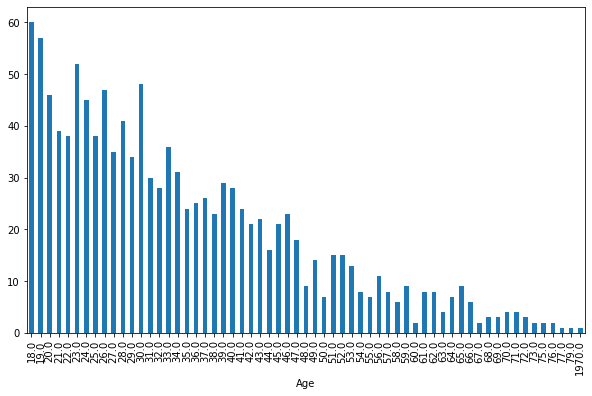

In [ ]:
data_set['Age'].value_counts().sort_index().plot.bar(figsize=(10,6))
plt.xlabel('Age')
plt.show()

Histogram of points to display outliers

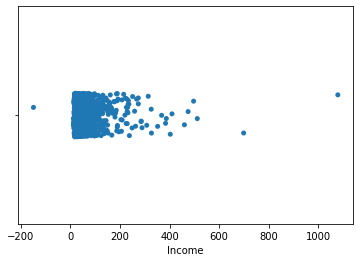

In [ ]:
sn.stripplot(x='Income', data=data_set) 
plt.show()

Color Histogram, to see relevance of the target variable in the values of a variable.

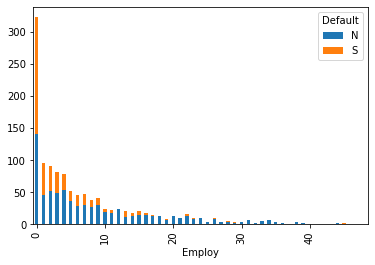

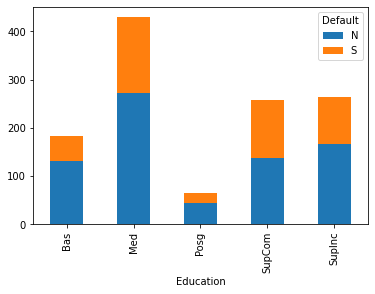

In [ ]:
data_set.groupby(['Employ', 'Default']).size().unstack().plot.bar(stacked=True) 
plt.xscale('linear')
plt.show()
data_set.groupby(['Education', 'Default']).size().unstack().plot.bar(stacked=True)
plt.show()


We can also make the histogram color with proportions.

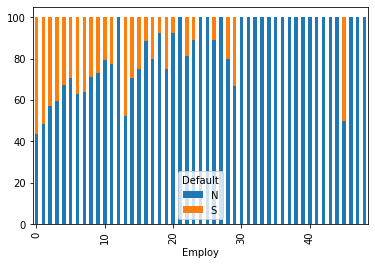

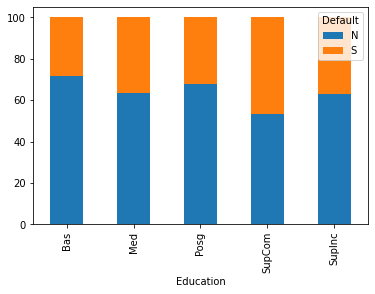

In [ ]:
data_set.groupby(['Employ', 'Default']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.xscale('linear')
plt.show()
data_set.groupby(['Education', 'Default']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.show()

Box plot

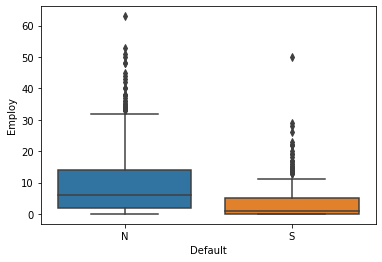

In [ ]:
sn.boxplot(x="Default", y="Employ", data=data_set) 
plt.show()

Point chart to see redundancy between two variables

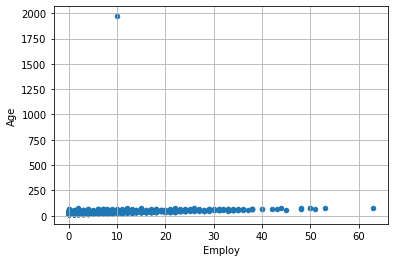

In [ ]:
data_set.plot(kind='scatter', x='Employ', y='Age', grid=True)
plt.show()



# Data cleansing

Data cleansing is to eliminate the inconsistencies found in exploratory analysis of data, such as lost values and atypical values, so that the database can work without altering the results.

First we declare outliers as lost values (inconsistencies) and then work them (imputating lost values).

## Inconsistencies

We declare values that are out of range as lost values, so that we can identify them.

In [ ]:
data_set.loc[data_set['Income'] < 0, ['Income']] = np.nan
data_set.loc[data_set['Age'] > 100, ['Age']] = np.nan

## Imputing lost values

Now we have to work these lost values, for that we have 3 alternatives:

**Option 1: Mean/mode Replacement**

We use this alternative when the lost values are less than 5% of the total data and consist of replacing the lost values with the mean/mode.

We replace with the mean in the numerical variables

In [ ]:
data_set['Age'].fillna(data_set['Age'].median(skipna=True), inplace=True)
data_set['Address'].fillna(data_set['Address'].median(skipna=True), inplace=True)
data_set['Income'].fillna(data_set['Income'].mean(skipna=True), inplace=True)
data_set['Debtinc'].fillna(data_set['Debtinc'].mean(skipna=True), inplace=True)

We replace with mode in categorical variables

In [ ]:
mode = data_set['Education'].mode()
data_set['Education'].fillna(mode[0], inplace=True)

But this has the disadvantage that we alter the results.

**Option 2: Elimination of cases**

We also use this alternative when the lost values are less than 5% of the total data and consists of deleting all rows where there is any null value. It does not alter the results but loses the information of the other variables in that row.

In [ ]:
data_set = data_set.dropna(axis=0, how='any')

**Option 3: Multiple imputation**

Multiple imputation consists of simulating the behavior of the data and from this replacing the values lost by the simulated data. The latter alternative is used when the lost values are less than 30% of the total data.

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=12700)
num = data_set.select_dtypes(include=["number"])
cat = data_set.select_dtypes(exclude=["number"])
names = num.columns
num = pd.DataFrame(imp.fit_transform(num))
num.columns = names
data_set = pd.concat([num, cat], axis=1)

We confirm that there are no missing values in the database

In [ ]:
data_set.isnull().sum()

customer       0
Age            0
Employ         0
Address        0
Income         0
Debtinc        0
Creddebt       0
OthDebt        0
Education      0
Nationality    0
Default        0
dtype: int64

We delete the customer variable because it is not necessary for the model

In [ ]:
del data_set['customer']

KeyError: ignored

# Transformation

Data transformation consists of improving the predictive value of a variable, giving mathematical meaning to variables, grouping data, and improving the ability to discriminate of a variable.

## We transform data to a new scale

First we see the distribution of asymmetric variables graphing them

In [ ]:
data_set['Income'].plot(kind='hist',bins=150, grid=True )
plt.show()
data_set['Creddebt'].plot(kind='hist',bins=60, grid=True)
plt.show()
data_set['OthDebt'].plot(kind='hist',bins=57, grid=True )
plt.show()


As we see the variable is concentrated in an interval, so we apply its logarithm:

In [ ]:
data_set['Ln_Income'] = np.log(data_set['Income']+1)
data_set['Ln_Creddebt'] = np.log(data_set['Creddebt']+1)
data_set['Ln_OthDebt'] = np.log(data_set['OthDebt']+1)

Now, if we graph their logarithms we can see that they have a normal distribution

In [ ]:
data_set['Ln_Income'].plot(kind='hist',bins=100, grid=True )
plt.show()
data_set['Ln_Creddebt'].plot(kind='hist',bins=40, grid=True )
plt.show()
data_set['Ln_OthDebt'].plot(kind='hist',bins=40, grid=True )
plt.show()

We remove the Income, Creddebt and OthDebt variables to stay with only their logarithms.

In [ ]:
del data_set['Income']
del data_set['Creddebt']
del data_set['OthDebt']

## Aggregation

For the Education variable we will group your data to reduce its classes. Therefore, we will join two classes into one, when the variable takes the value of full and postgraduate higher education, as shown in the example below:

SupCom + Posg = Completa

What translates into the code:

In [ ]:
data_set['Education'] = data_set['Education'].replace('SupCom', 'Completa')
data_set['Education'] = data_set['Education'].replace('Posg', 'Completa')

## We transform data into binary variables

We transform the categorical variables of the database to binary variables

To transform all categorical variables in the database to binary variables:

In [ ]:
'''
we define another data_set to be able to execute the two codes, otherwise
there will be no variables to transform in the following example
'''
data_set_T = data_set 
data_set_T = pd.get_dummies(data_set_T, drop_first= True)
data_set_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1200 non-null   float64
 1   Employ              1200 non-null   float64
 2   Address             1200 non-null   float64
 3   Debtinc             1200 non-null   float64
 4   Ln_Income           1200 non-null   float64
 5   Ln_Creddebt         1200 non-null   float64
 6   Ln_OthDebt          1200 non-null   float64
 7   Education_Completa  1200 non-null   uint8  
 8   Education_Med       1200 non-null   uint8  
 9   Education_SupInc    1200 non-null   uint8  
 10  Default_S           1200 non-null   uint8  
dtypes: float64(7), uint8(4)
memory usage: 70.4 KB


To transform a database-specific categorical variable to binary variable:

In [ ]:
data_set = pd.get_dummies(data_set, columns = ["Default"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["Nationality"]) #without drop_first because everyone takes the same value then eliminates it
data_set = pd.get_dummies(data_set, columns = ["Education"], drop_first=True) 
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1200 non-null   float64
 1   Employ              1200 non-null   float64
 2   Address             1200 non-null   float64
 3   Debtinc             1200 non-null   float64
 4   Ln_Income           1200 non-null   float64
 5   Ln_Creddebt         1200 non-null   float64
 6   Ln_OthDebt          1200 non-null   float64
 7   Default_S           1200 non-null   uint8  
 8   Nationality_N       1200 non-null   uint8  
 9   Education_Completa  1200 non-null   uint8  
 10  Education_Med       1200 non-null   uint8  
 11  Education_SupInc    1200 non-null   uint8  
dtypes: float64(7), uint8(5)
memory usage: 71.6 KB


## Normalization

Standardization consists of standardizing the database to match the treatment of each variable.

In [ ]:
#data_set_scaled = preprocessing.StandardScaler() 
#data_set_scaled = pd.DataFrame(data_set_scaled.fit_transform(data_set), columns = data_set.columns)

## Discretization

Discretization is about transforming continuous variables into categorical variables. With this we increase the variables to create better discrimination of them.

**We discretize the Age variable**

We have to establish a criterion to divide the variables, in this case we will do it by quantity.

We define the split points to use:



In [ ]:
cut_points = data_set['Age'].quantile([0, .2, .4, .6, .8, 1]) #the array is how I want to divide the data

Now we discretize the Age variable with the defined points:

In [ ]:
Age_binned = pd.cut(data_set['Age'], bins =cut_points, include_lowest= True ) # bins can be an int also with the number of dividations in the interval and based on that divides it
print(Age_binned)

0       (22.8, 28.0]
1       (45.0, 79.0]
2       (35.0, 45.0]
3       (28.0, 35.0]
4       (22.8, 28.0]
            ...     
1195    (22.8, 28.0]
1196    (45.0, 79.0]
1197    (45.0, 79.0]
1198    (45.0, 79.0]
1199    (28.0, 35.0]
Name: Age, Length: 1200, dtype: category
Categories (5, interval[float64]): [(17.999, 22.8] < (22.8, 28.0] < (28.0, 35.0] < (35.0, 45.0] <
                                    (45.0, 79.0]]


Then Age_binned will be the discretized Age variable.

**We discretize the Address variable**

We do the same analysis as for the Age variable.

In [ ]:
cut_points = data_set['Address'].quantile([0, .2, .4, .6, .8, 1]) 
Address_binned = pd.cut(data_set['Address'], bins =cut_points, include_lowest= True )
print(Address_binned)

0         (1.0, 3.0]
1       (11.0, 34.0]
2       (11.0, 34.0]
3         (1.0, 3.0]
4         (1.0, 3.0]
            ...     
1195      (1.0, 3.0]
1196    (11.0, 34.0]
1197    (11.0, 34.0]
1198    (11.0, 34.0]
1199     (6.0, 11.0]
Name: Address, Length: 1200, dtype: category
Categories (5, interval[float64]): [(-0.001, 1.0] < (1.0, 3.0] < (3.0, 6.0] < (6.0, 11.0] <
                                    (11.0, 34.0]]


Then Address_binned the discretized Address variable will be.

# Filters (Attribute selection)

Filters are used to choose a subset of relevant variables, eliminating noise-generating variables and confusing the model.

There are 3 criteria:

## Inutility

This criterion is to find highly concentrated variables within the database.

For this we calculate the standard deviation of the variables:

In [ ]:
data_set.std()

Age                   13.235918
Employ                 9.172897
Address                6.092325
Debtinc                6.856562
Ln_Income              0.666340
Ln_Creddebt            0.628778
Ln_OthDebt             0.725148
Default_S              0.483672
Nationality_N          0.000000
Education_Completa     0.443712
Education_Med          0.479711
Education_SupInc       0.413854
dtype: float64

We ruled out Nationality because its standard deviation is 0

In [ ]:
del data_set['Nationality_N']

## Redundance

This criterion is to find variables that are highly correlated because they deliver similar results.

We calculate the correlation matrix between all variables in the database:

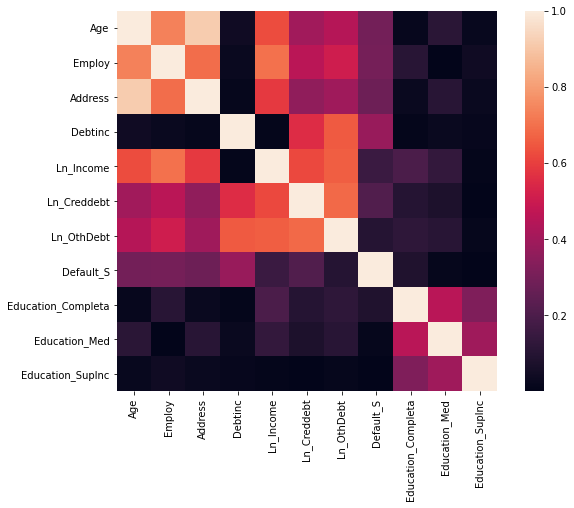

In [ ]:
corrmat = data_set.corr().abs()
f, ax = plt.subplots(figsize=(10, 7))
sn.heatmap(corrmat, square=True);

## Relevance

Finally this criterion is to see which variables are most relevant to predicting the target variable.

We will use the chi squared test that calculates the relationship between two nominal variables.

**We calculate the relationship between the Age variable and Default**

To be able to perform the test we have to use two categorical variables, so we occupy the discretized Age variable.


We create the contingency table between the two variables:

In [ ]:
tbl = pd.crosstab(index=Age_binned,columns=data_set['Default_S'])
print(tbl)
data_set.describe(include='all') 

Default_S         0    1
Age                     
(17.999, 22.8]  106  134
(22.8, 28.0]    136  122
(28.0, 35.0]    145   88
(35.0, 45.0]    167   68
(45.0, 79.0]    199   35


,Age,Employ,Address,Debtinc,Ln_Income,Ln_Creddebt,Ln_OthDebt,Default_S,Education_Completa,Education_Med,Education_SupInc
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,34.342500,7.062500,6.386667,10.192494,3.836314,0.853693,1.301167,0.372500,0.269167,0.358333,0.219167
std,13.235918,9.172897,6.092325,6.856562,0.666340,0.628778,0.725148,0.483672,0.443712,0.479711,0.413854
min,18.000000,0.000000,0.000000,0.100000,2.564949,0.009950,0.009950,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2.000000,4.900000,3.367296,0.362901,0.759635,0.000000,0.000000,0.000000,0.000000
50%,31.000000,4.000000,5.000000,8.800000,3.713572,0.717840,1.201469,0.000000,0.000000,0.000000,0.000000
75%,42.000000,10.000000,9.250000,13.900000,4.189655,1.205971,1.747894,1.000000,1.000000,1.000000,0.000000
max,79.000000,63.000000,34.000000,40.700000,6.984716,3.610107,4.166200,1.000000,1.000000,1.000000,1.000000


We perform the chi square test from the table and get its results:

In [ ]:
stat, p, dof, expected = chi2_contingency(tbl)
# print the test results
print('Pearsons Chi-squared test')
print('X-squared = %d' % stat) 
print('P-value =%d' % p)
print('dof = %d' % dof)

Pearsons Chi-squared test
X-squared = 103
P-value =0
dof = 4


**We calculate the relationship between the Address variable and Default**

We do the same analysis above.

In [ ]:
tbl = pd.crosstab(index=Address_binned, columns=data_set['Default_S'])
print(tbl)
stat, p, dof, expected = chi2_contingency(tbl)
print('Pearsons Chi-squared test')
print('X-squared = %d' % stat) 
print('P-value =%d' % p)
print('dof = %d' % dof)

Default_S        0    1
Address                
(-0.001, 1.0]  126  162
(1.0, 3.0]     113   88
(3.0, 6.0]     145   92
(6.0, 11.0]    192   72
(11.0, 34.0]   177   33
Pearsons Chi-squared test
X-squared = 101
P-value =0
dof = 4


Finally we ruled out Address as it is redundant and less relevant than Age

In [ ]:
del data_set['Address']

**Selection of most relevant variables with chi square test**

We select the 5 variables that have the largest chi square statistic, as shown below:

First we define as X the independent variables and as Y the dependent variable:

In [ ]:
X = data_set.loc[:, data_set.columns != 'Default_S'] 
y = data_set.loc[:, data_set.columns == 'Default_S']
X.shape

(1200, 9)

Now we apply the SelectKBest function with the chi squared test to determine the most relevant variables:

In [ ]:
X_new = SelectKBest(chi2, k=5).fit(X, y)
#para que devuleva una matriz con lo valores de las variables mas relevantes (numpy array) 
#no se si es necesario poner esto
x_final = X_new.fit_transform(X,y) 
x_final.shape
print(x_final)

[[28.          7.         17.7         1.38379123  0.        ]
 [64.         34.         14.7         1.80005827  1.        ]
 [40.         20.          4.8         0.71294981  0.        ]
 ...
 [51.          9.         14.6         0.91629073  0.        ]
 [57.         31.          1.4         1.08518927  1.        ]
 [33.          3.         12.8         0.65232519  0.        ]]


Finally, we can get the names of the selected columns:

In [ ]:
kbest = np.asarray(X.columns)[X_new.get_support()]
print(kbest)

['Age' 'Employ' 'Debtinc' 'Ln_Creddebt' 'Education_Completa']


**Standardization**

In [ ]:
Default = data_set['Default_S']
scaler = MinMaxScaler()
scaler_data = scaler.fit(data_set)
data_set_scaled = pd.DataFrame(scaler_data.transform(data_set), index=data_set.index, columns=data_set.columns)
data_set_scaled['Default_S'] = Default
print(data_set_scaled)

           Age    Employ  ...  Education_Med  Education_SupInc
0     0.163934  0.111111  ...            1.0               0.0
1     0.754098  0.539683  ...            0.0               0.0
2     0.360656  0.317460  ...            0.0               0.0
3     0.196721  0.174603  ...            0.0               0.0
4     0.114754  0.031746  ...            0.0               0.0
...        ...       ...  ...            ...               ...
1195  0.098361  0.015873  ...            0.0               0.0
1196  0.885246  0.761905  ...            1.0               0.0
1197  0.540984  0.142857  ...            1.0               0.0
1198  0.639344  0.492063  ...            0.0               0.0
1199  0.245902  0.047619  ...            0.0               1.0

[1200 rows x 10 columns]
